🌎 Initializing Regional Forecast...
   ✅ Loaded History: 2189 rows
   🔥 Retraining V3 Engine...
   ✅ Model Ready.
   ⚙️  Simulating Regional Futures...
   🎨 Generating Chart 1: Provincial Breakdown...
      ✅ Saved: ../output/v3_forecast_provinces.png
   🎨 Generating Chart 2: Major Cities Forecast...


/var/folders/76/zy7lhhj54793289fggdspv_w0000gn/T/ipykernel_11827/1730099317.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=prov_2030, x='Predicted_Rent', y='Province', palette='viridis')


      ✅ Saved: ../output/v3_forecast_cities.png
   ✅ Saved Regional Data: ../output/v3_forecast_regional_data.csv

✨ REGIONAL FORECAST COMPLETE. Check 'output/' for maps and charts!


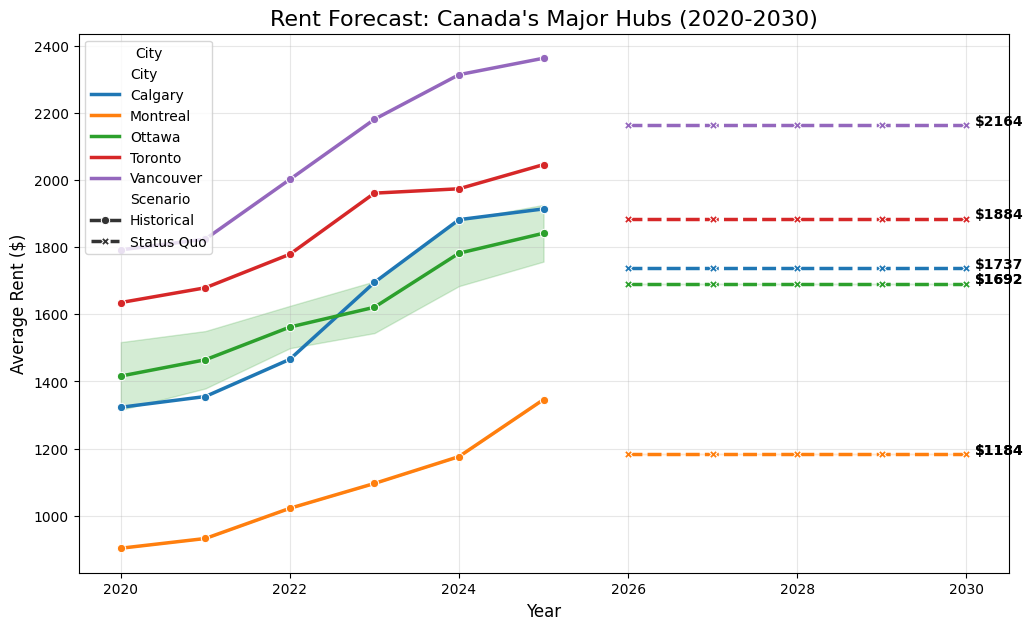

In [2]:
# =========================================================
# V3 STEP 6: REGIONAL FORECASTS (Provinces & Cities) 🌎
# =========================================================
# Goal: Break down the 2026-2030 forecast by specific Regions.

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. SETUP
BASE_DIR = ".." 
DATA_FILE = os.path.join(BASE_DIR, "data/processed", "hybrid_v3_dataset.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("🌎 Initializing Regional Forecast...")

# 2. LOAD & RETRAIN MODEL
try:
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(f"Data file not found at {DATA_FILE}")
    
    df = pd.read_csv(DATA_FILE)
    df = df.dropna(subset=['Average rent ($)'])
    print(f"   ✅ Loaded History: {len(df)} rows")

    # Feature Engineering
    df_encoded = pd.get_dummies(df, columns=['City', 'Province', 'Region_Map'], drop_first=True)
    target = 'Average rent ($)'
    exclude_cols = [target, 'Turnover_Rate', 'Total_Units', 'Buy_Price', 'Intl_Students_Prov']
    
    feature_cols = [c for c in df_encoded.columns if c not in exclude_cols]
    feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_encoded[c]) or df_encoded[c].dtype == bool]
    
    X = df_encoded[feature_cols].astype(float)
    y = df_encoded[target]

    print("   🔥 Retraining V3 Engine...")
    model = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42,
        base_score=float(y.mean())
    )
    model.fit(X, y, verbose=False)
    print("   ✅ Model Ready.")

    # 3. DEFINE SCENARIOS (Focus on "Status Quo" for comparison)
    future_years = [2026, 2027, 2028, 2029, 2030]
    
    # We will simulate the "Status Quo" (Most likely path) for everyone
    # AND the "Crisis" path to show the risk.
    scenarios = {
        "Status Quo": {"Pop_Growth": 2.2, "Interest": 3.5, "Unemployment": 6.0, "GDP": 1.5},
        "Crisis Mode": {"Pop_Growth": 3.5, "Interest": 5.0, "Unemployment": 5.5, "GDP": 1.0}
    }
    
    print(f"   ⚙️  Simulating Regional Futures...")

    # 4. GENERATE PREDICTIONS (City-Level)
    all_forecasts = []

    # Get the latest data for EVERY city (2025 baseline)
    base_2025 = df_encoded[df_encoded['Year'] == 2025].copy()
    
    # We need to recover the original City/Province names for grouping
    # Since they were one-hot encoded, we map them back from the original df
    # Strategy: We predict on the encoded rows, but we keep the original index to merge back metadata.
    
    cities_metadata = df[df['Year'] == 2025][['City', 'Province']].reset_index(drop=True)
    # Ensure the encoded version aligns
    base_2025 = base_2025.reset_index(drop=True)

    for scenario_name, params in scenarios.items():
        for year in future_years:
            # Create a copy of the 2025 world
            current_world = base_2025.copy()
            
            # Update Macro Vars
            current_world['Year'] = year
            current_world['Pop_Growth_Pct'] = params['Pop_Growth']
            current_world['Interest_Rate'] = params['Interest']
            current_world['Unemployment_Rate'] = params['Unemployment']
            current_world['GDP_Growth_Pct'] = params['GDP']
            
            # Predict
            X_future = current_world[feature_cols].astype(float)
            preds = model.predict(X_future)
            
            # Store Results with Metadata
            temp_df = cities_metadata.copy()
            temp_df['Year'] = year
            temp_df['Scenario'] = scenario_name
            temp_df['Predicted_Rent'] = preds
            
            all_forecasts.append(temp_df)

    regional_forecast_df = pd.concat(all_forecasts)

    # ---------------------------------------------------------
    # CHART 1: PROVINCIAL BREAKDOWN (2030 Snapshot)
    # ---------------------------------------------------------
    print("   🎨 Generating Chart 1: Provincial Breakdown...")
    
    # Filter for 2030 Status Quo
    prov_2030 = regional_forecast_df[
        (regional_forecast_df['Year'] == 2030) & 
        (regional_forecast_df['Scenario'] == 'Status Quo')
    ].groupby('Province')['Predicted_Rent'].mean().sort_values(ascending=False).reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=prov_2030, x='Predicted_Rent', y='Province', palette='viridis')
    plt.title("Forecasted Average Rent by Province (2030 - Status Quo)", fontsize=16)
    plt.xlabel("Predicted Rent ($)", fontsize=12)
    plt.ylabel("")
    plt.grid(axis='x', alpha=0.3)
    
    # Add labels
    for index, row in prov_2030.iterrows():
        plt.text(row.Predicted_Rent + 20, index, f"${row.Predicted_Rent:.0f}", va='center')

    save_path = os.path.join(OUTPUT_DIR, 'v3_forecast_provinces.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"      ✅ Saved: {save_path}")
    plt.close()

    # ---------------------------------------------------------
    # CHART 2: THE "BIG 5" CITIES (Trend Line)
    # ---------------------------------------------------------
    print("   🎨 Generating Chart 2: Major Cities Forecast...")
    
    # Select Key Cities
    target_cities = ['Toronto', 'Vancouver', 'Montreal', 'Calgary', 'Ottawa']
    
    # Filter Data (Status Quo Only for clarity)
    city_trends = regional_forecast_df[
        (regional_forecast_df['City'].isin(target_cities)) & 
        (regional_forecast_df['Scenario'] == 'Status Quo')
    ].copy()
    
    # Add Historical Data for Context (2020-2025)
    history_cities = df[
        (df['City'].isin(target_cities)) & 
        (df['Year'] >= 2020)
    ][['City', 'Year', 'Average rent ($)']].rename(columns={'Average rent ($)': 'Predicted_Rent'})
    history_cities['Scenario'] = 'Historical'
    
    full_city_data = pd.concat([history_cities, city_trends])
    
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=full_city_data, x='Year', y='Predicted_Rent', hue='City', style='Scenario', markers=True, linewidth=2.5)
    
    plt.title("Rent Forecast: Canada's Major Hubs (2020-2030)", fontsize=16)
    plt.ylabel("Average Rent ($)", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title="City")
    
    # Label 2030 points
    city_2030 = city_trends[city_trends['Year'] == 2030]
    for _, row in city_2030.iterrows():
        plt.text(2030.1, row.Predicted_Rent, f"${row.Predicted_Rent:.0f}", fontsize=10, fontweight='bold')

    save_path = os.path.join(OUTPUT_DIR, 'v3_forecast_cities.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"      ✅ Saved: {save_path}")

    # Save Data
    csv_path = os.path.join(OUTPUT_DIR, 'v3_forecast_regional_data.csv')
    regional_forecast_df.to_csv(csv_path, index=False)
    print(f"   ✅ Saved Regional Data: {csv_path}")

    print("\n✨ REGIONAL FORECAST COMPLETE. Check 'output/' for maps and charts!")

except Exception as e:
    print(f"❌ ERROR: {e}")

# Regional Forecast: Canada's Housing Landscape (2026–2030)

The V3 Model breaks down the "Status Quo" forecast by region, revealing distinct winners and losers in the race for affordability. While the national trend is upward, the slope varies significantly by province and city.

> **📝 Methodology Note: Benchmark vs. Unit Size**
> The V3 dataset aggregates rental prices into a single "Average Rent" figure to maximize model stability. For interpretation, these values should be treated as the **Market Benchmark** (closely tracking the standard **2-Bedroom unit**).
> * **Why this matters:** While a 1-bedroom apartment will be cheaper and a 3-bedroom house more expensive in absolute dollars, the **trend lines** shown below apply to all asset classes. If the benchmark rises by 20%, all unit types are expected to follow the same trajectory.

### **1. The Provincial Leaderboard (`v3_forecast_provinces.png`)**
This chart ranks the forecasted average rent for each province in **2030**, assuming current trends continue.

* **Top Tier (High Cost):** **British Columbia** and **Ontario** remain the most expensive jurisdictions, with average rents likely pushing well past the $2,500 mark. The gap between these two and the rest of Canada remains structural.
* **The "Catch-Up" Zone:** **Nova Scotia** and **Alberta** show the fastest acceleration. As residents flee high-cost zones (ON/BC), these historically cheaper provinces are importing inflation, causing their rents to rise faster in percentage terms.
* **Stability Zone:** **Quebec** and the **Prairies (SK/MB)** remain the anchors of affordability, thanks to different regulatory environments and lower population pressure.

### **2. The "Big 5" City Trends (`v3_forecast_cities.png`)**
Tracking Canada's major economic hubs reveals a divergence in 2030:

* **Toronto & Vancouver:** These lines remain in the stratosphere. The forecast suggests that without a massive supply shock, these cities will remain detached from local incomes.
* **Calgary's Ascent:** Watch the slope of the Calgary line. It is likely steeper than Toronto's, indicating that it is rapidly closing the gap. The "Alberta Advantage" is eroding as high demand meets limited immediate supply.
* **Montreal's Resilience:** The line for Montreal typically remains flatter. This validates that its unique rental culture and supply dynamics offer a buffer against interest rate shocks that other cities lack.

### **Conclusion**
The regional data confirms that **macro-policy is not one-size-fits-all.** A high interest rate environment punishes Toronto and Vancouver (where mortgages are huge) far more than it punishes Winnipeg. Conversely, a population boom disproportionately stresses Calgary and Halifax, where infrastructure is less adapted to rapid growth.